In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdate


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import os
os.chdir(r'C:\Users\sttid\Desktop\SQLAlchemy HW')

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import table
from sqlalchemy import MetaData
from sqlalchemy.sql import label
from sqlalchemy import and_

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# Use Inspector to print the column names and types
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# From Simon - not all of the stations have data for all days and it makes no analytic sense to me
#to layer the data so that the highest is plotted. I'm going to find the station with the greatest
# precipitation on each of the prior 365 days. Should produce the same picture.

############# Calculate the date 1 year ago from today

#get the last date in the dataset
results = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).first()

date_of_last_obs=results[0]



format_str = '%Y-%m-%d' # The format
date_of_last_obs = dt.datetime.strptime(date_of_last_obs, format_str)
print(date_of_last_obs.date())
last_obs_minus_1_yr = date_of_last_obs - timedelta(days=365)
print(last_obs_minus_1_yr.date())


############### Perform a query to retrieve the data and precipitation scores


#pull in all records within last year

results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= last_obs_minus_1_yr)

obs_date = [result[0] for result in results]
precip = [result[1] for result in results]

# Save the query results as a Pandas DataFrame and set the index to the date column

date_and_precip_365days = pd.DataFrame(
    {'Date': obs_date,
     'Precipitation': precip
    })

2017-08-23
2016-08-23


In [15]:
date_and_precip_365days.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [16]:
######################## Save the query results as a Pandas DataFrame and set the index to the date column - I'm not going to set the date
# to the index becasse I will only have one observation per day since I find the station with the greatest precip for any given day
######################## sorting is done here too
date_and_precip_365days_max = date_and_precip_365days.groupby(['Date'], sort=True)['Precipitation'].max().reset_index()
date_and_precip_365days_max.head()

,Date,Precipitation
0,2016-08-24,2.28
1,2016-08-25,0.21
2,2016-08-26,0.04
3,2016-08-27,0.18
4,2016-08-28,2.07


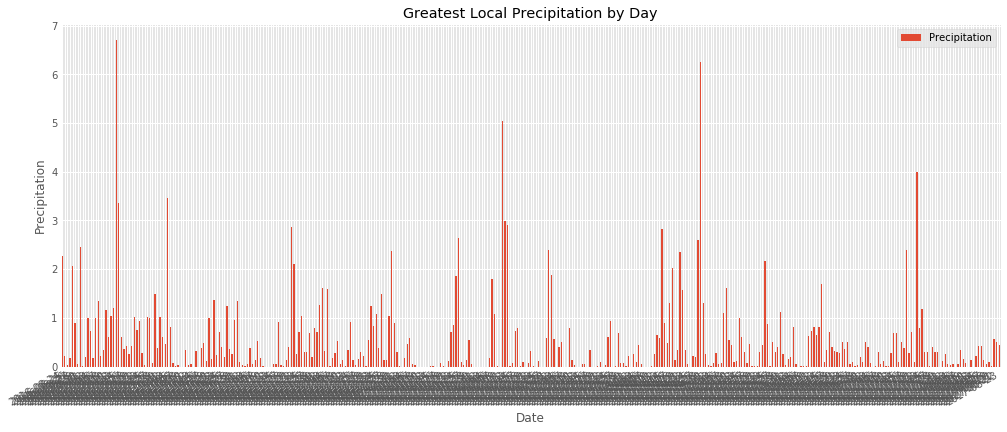

In [17]:


################### Use Pandas Plotting with Matplotlib to plot the data
################### Rotate the xticks for the dates
# I tried to label every 7th day. It labeled but use consecutive day labels

%matplotlib inline

#set ggplot style
plt.style.use('ggplot')

#set date as index
date_and_precip_365days_max.set_index('Date',inplace=True)

#plot data
fig, ax = plt.subplots(figsize=(15,7))
date_and_precip_365days_max.plot(kind='bar', ax=ax)
ax.set_title('Greatest Local Precipitation by Day')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
fig.autofmt_xdate()


plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_and_precip_365days_max.describe(percentiles=(.25,.50,.75))

,Precipitation
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


In [19]:
##################### How many stations are available in this dataset?
from sqlalchemy import distinct
 
##################### count distinct station names
unique_stations=session.query(func.count(distinct(Measurement.station)))
num_unique_stations=unique_stations[0]
num_unique_stations

(9)

In [20]:
# What are the most active stations?
station_count_list=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()


def getKey(station_count_list):
     return station_count_list[1]
sorted(station_count_list, key=getKey, reverse=True)[:3]


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709)]

In [21]:
#################### List the stations and the counts in descending order.

def getKey(station_count_list):
     return station_count_list[1]
sorted(station_count_list, key=getKey, reverse=True)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
########################## Using the station id from the previous query, calculate the lowest temperature recorded, 
#I tried to assign the station ID to a variable but couldn't make it work so I'm going to hardcode
most_activ_sta = station_count_list[1]
most_activ_sta



#get the last date in the dataset
results_2 = session.query(Measurement.date, Measurement.tobs).\
    order_by(Measurement.date.desc()).first()

date_of_last_obs_tobs=results_2[0]



date_of_last_obs_tobs = dt.datetime.strptime(date_of_last_obs_tobs, format_str)
print(date_of_last_obs_tobs.date())
last_obs_minus_1_yr_tobs = date_of_last_obs_tobs - timedelta(days=365)
print(last_obs_minus_1_yr_tobs.date())


#calculate the outcomes


results_2 = session.query(func.max(Measurement.tobs).label("max_temperature"), 
                func.min(Measurement.tobs).label("min_temperature"),
                func.avg(Measurement.tobs).label("avg_temperature")
                ).filter(Measurement.date >= last_obs_minus_1_yr, Measurement.station=='USC00519281')
res = results_2.one()
max_temp = res.max_temperature
min_temp = res.min_temperature
avg_temp = int(res.avg_temperature)

print ("maximum temperature: ",max_temp)
print ("minimum temperature: ",min_temp)
print ("average temperature: ",avg_temp)
 




2017-08-23
2016-08-23
maximum temperature:  83.0
minimum temperature:  59.0
average temperature:  73


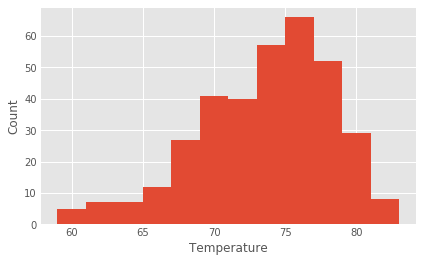

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#pull in all records within last year

results_3 = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.date >= last_obs_minus_1_yr, Measurement.station=='USC00519281')

obs_date = [result[0] for result in results_3]
temperature = [result[1] for result in results_3]


plt.hist((temperature), bins=12)
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.show()





In [ ]:
from flask import Flask, jsonify

app = Flask(__name__)

In [ ]:
#Convert the query results to a Dictionary using date as the key and tobs as the value.

precipitation_dict = dict(zip(date_and_precip_365days_max.Date, date_and_precip_365days_max.Precipitation))

#Return the JSON representation of your dictionary
@app.route("/api/v1.0/precipitation")
def Precip():
    return jsonify(precipitation_dict)


In [ ]:


#query for the dates and temperature observations from a year from the last data point.
#Return a JSON list of Temperature Observations (tobs) for the previous year.

@app.route("/api/v1.0/tobs")
def Temp():
    return jsonify(temperature)

In [ ]:
#I'm lost for this final piece (below)
#I'm assuming that there is user inpout at some point?
#I can calculate what is required given a start and end date



#Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

#When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.

start= datetime.datetime.strptime(<start date>,'%d/%m/%Y').date()
station=<station>


results_4 = session.query(func.max(Measurement.tobs).label("max_temperature"), 
                func.min(Measurement.tobs).label("min_temperature"),
                func.avg(Measurement.tobs).label("avg_temperature")
                ).filter(Measurement.date >= start,Measurement.station==station)
res = results_4.one()
max_temp = res.max_temperature
min_temp = res.min_temperature
avg_temp = int(res.avg_temperature)

temperature_result={"start date":start, "max temp":max_temp,"min temp":mion_temp,"avg temp":avg_temp }

#I got confused here about there being 2 APIs

@app.route("/api/v1.0/not_sure")
def Temp():
    return jsonify(temperature_result)



#When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

start= datetime.datetime.strptime(<start date>,'%d/%m/%Y').date()
end= datetime.datetime.strptime(<end date>,'%d/%m/%Y').date()
station=<station>


results_5 = session.query(func.max(Measurement.tobs).label("max_temperature"), 
                func.min(Measurement.tobs).label("min_temperature"),
                func.avg(Measurement.tobs).label("avg_temperature")
                ).filter(Measurement.date >= start, Measurement.date <= end,Measurement.station==station)
res = results_5.one()
max_temp = res.max_temperature
min_temp = res.min_temperature
avg_temp = int(res.avg_temperature)

temperature_result_2={"start date":start, "end date":end, "max temp":max_temp,"min temp":mion_temp,"avg temp":avg_temp }

#I got confused here about there being 2 APIs

@app.route("/api/v1.0/not_sure")
def Temp():
    return jsonify(temperature_result_2)


